In [1]:
import arviz as az
import numpy as np
import pandas as pd
import warnings
from scipy.interpolate import BSpline
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [2]:
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"

In [3]:
def is_sorted(a):
    '''Check if numpy 1d-array is sorted
    '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a)))
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape))
    return np.all(a[:-1] <= a[1:])

def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x),type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0)
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

def get_quantiles(fx, probs=None):
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even')
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)')
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2))))
    return np.percentile(fx, probs, axis=0)


def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x).
    x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca()
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx)
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")    
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]

    for i in range(int(nq/2)):
        ax.fill_between(x,
                        perc_interv[i,:],
                        perc_interv[-(i+1),:],
                        color=colortab[i],
                        zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder)
    return ax
def mahalanobis_depth(x,x_bar,invSigma):
    dev=np.expand_dims(x-x_bar,axis=1)
    MD=dev.T@invSigma@dev
    return np.asscalar(1/(1+MD))

def create_spline_matrix(N,T,time,spl_order=3,num_knots=7):
    '''
    N - Number of time series,
    T - number of samples
    time - array/series of time values
    
    '''
    time=np.array(time) 
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    knots = np.pad(knot_list, (spl_order, spl_order), mode="edge")
    B = BSpline(knots, np.identity(num_knots + 2),
                k=spl_order)(time[0:T])
    # Design matrix
    return np.tile(B, (N, 1))

In [4]:
# number of trajectories
N = 10 
# number of samples per trajectory
M=100

trajectories1 = pd.read_csv('ptp_currents.csv',index_col=0)
spl_order = 3
num_knots = 15
time=trajectories1.time.values
knot_list = np.quantile(time, np.linspace(0, 1, num_knots))

BN = create_spline_matrix(N,M,time,spl_order,num_knots)
B0 = BN[0:M]


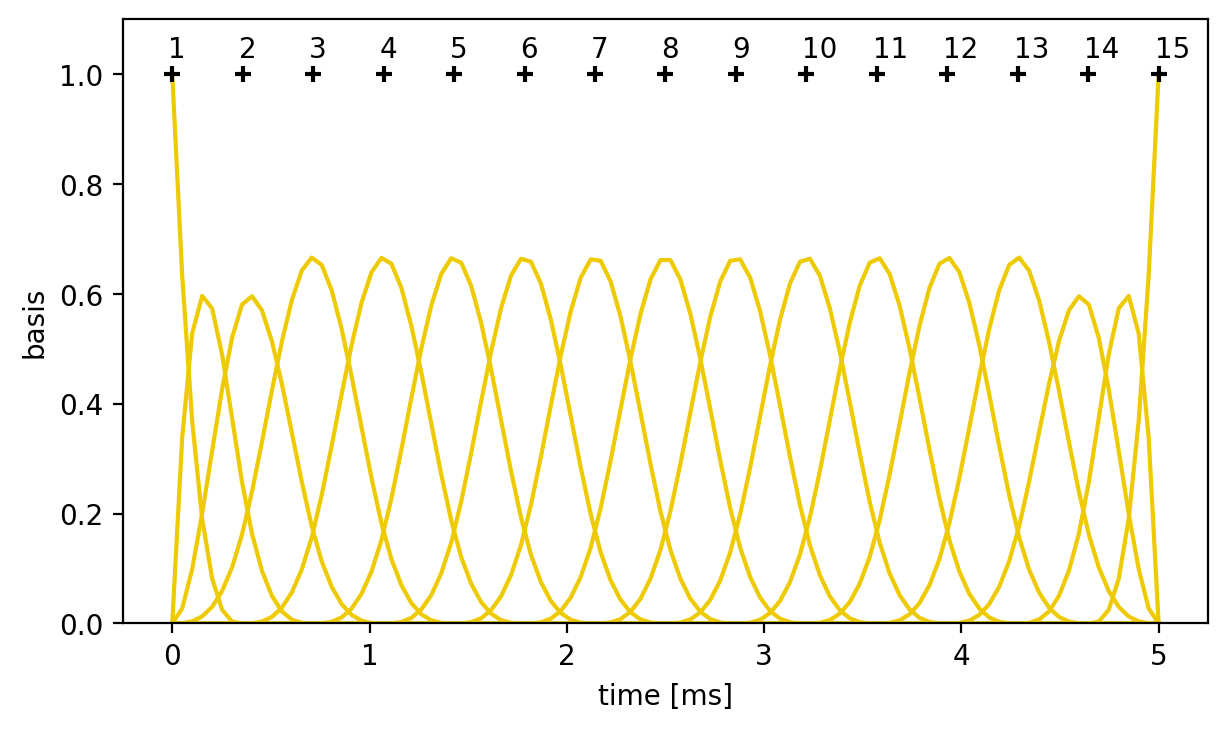

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for i in range(num_knots+2):
    ax.plot(time, (B0[:, i]), color=DARK,zorder=0)
    if i<num_knots:
        ax.text(s='{}'.format(i+1),x=knot_list[i]-0.02,y=1.03)
        ax.scatter(knot_list[i],1,marker='+',color='black',zorder=1)
ax.set_ylim((0,1.1))
ax.set_xlabel("time [ms]")
ax.set_ylabel("basis")
fig.savefig('spline_base.pdf',bbox_inches='tight')

In [6]:
spline_fit = CmdStanModel(stan_file='spline_fit_4.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/cables/spline_fit_4


In [7]:
melted_traj = pd.melt(trajectories1, id_vars=['time'], value_vars=trajectories1.columns[0:100],var_name='experiment', value_name='current')
melted_traj['voltage'] = pd.melt(pd.read_csv('ptp_voltages.csv',index_col=0),id_vars=['time'], value_vars=trajectories1.columns[0:100],var_name='experiment', value_name='voltage')['voltage']

In [8]:
data_current = dict(N=BN.shape[0],
                 K=BN.shape[1],
                 L=M,
                 x=BN,
                 y=melted_traj.current.values[0:N*M])

In [9]:
fit_current = spline_fit.sample(data = data_current, seed = 14082021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [10]:
y_pred = fit_current.stan_variable('y_pred')
beta_healthy = fit_current.stan_variable('beta')
mu = fit_current.stan_variable('mu')

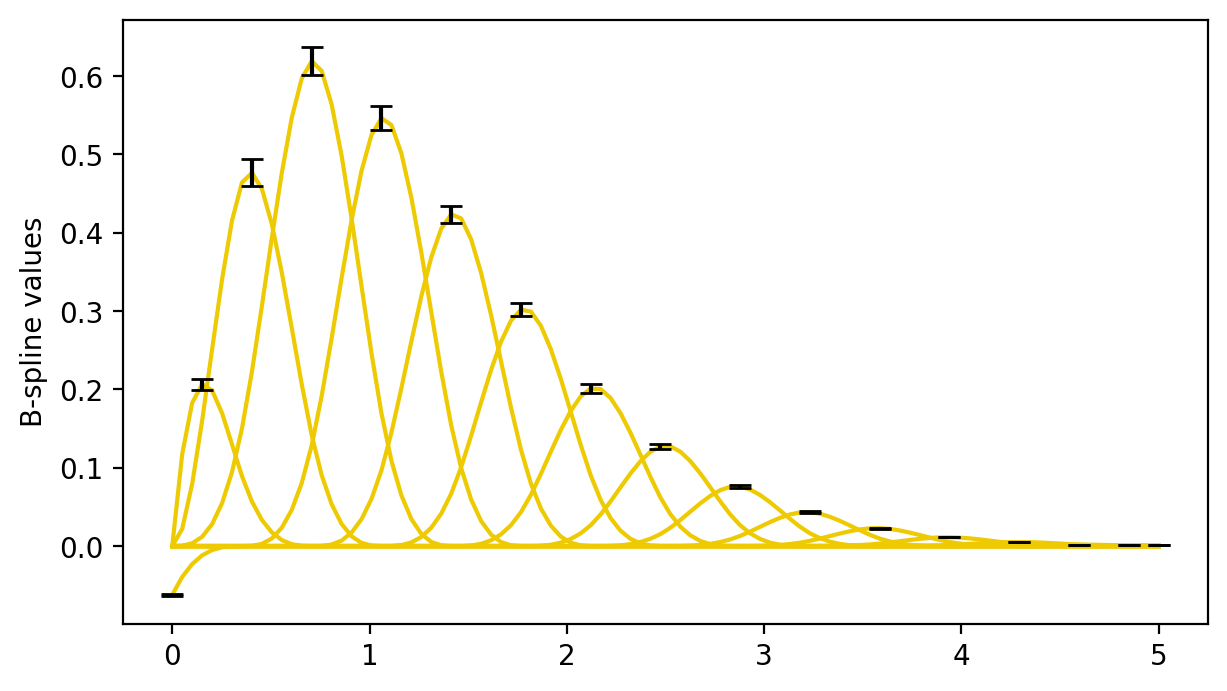

In [11]:
# srednie i odchylenia standardowe (brzegowe dla wspolczynnikow)
mn_beta = np.mean(beta_healthy, axis=0)
sd_beta = np.std(beta_healthy, axis=0)


# Visualisation of individual splines
B0 = BN[0:M]
spline_components = B0@np.diag(mn_beta)
y_m = 0*mn_beta
for i in range(len(y_m)):
    y_m[i] = max(spline_components[:,i].min(), spline_components[:,i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax_spl = plt.subplots(1, 1, figsize=(7, 4), sharex=True)
# #ax2.set_ylim((-1, 14))
for i in range(num_knots+2):
     ax_spl.plot(time,(spline_components[:, i]), color=DARK, zorder=0)
     ax_spl.errorbar(time[x_m[i]], y_m[i], ls='none', yerr=2 * sd_beta[i]*y_m[i], color='black', capsize=4)
ax_spl.set_ylabel('B-spline values')

plt.show()

fig.savefig('spline_current_fit.pdf',bbox_inches='tight')

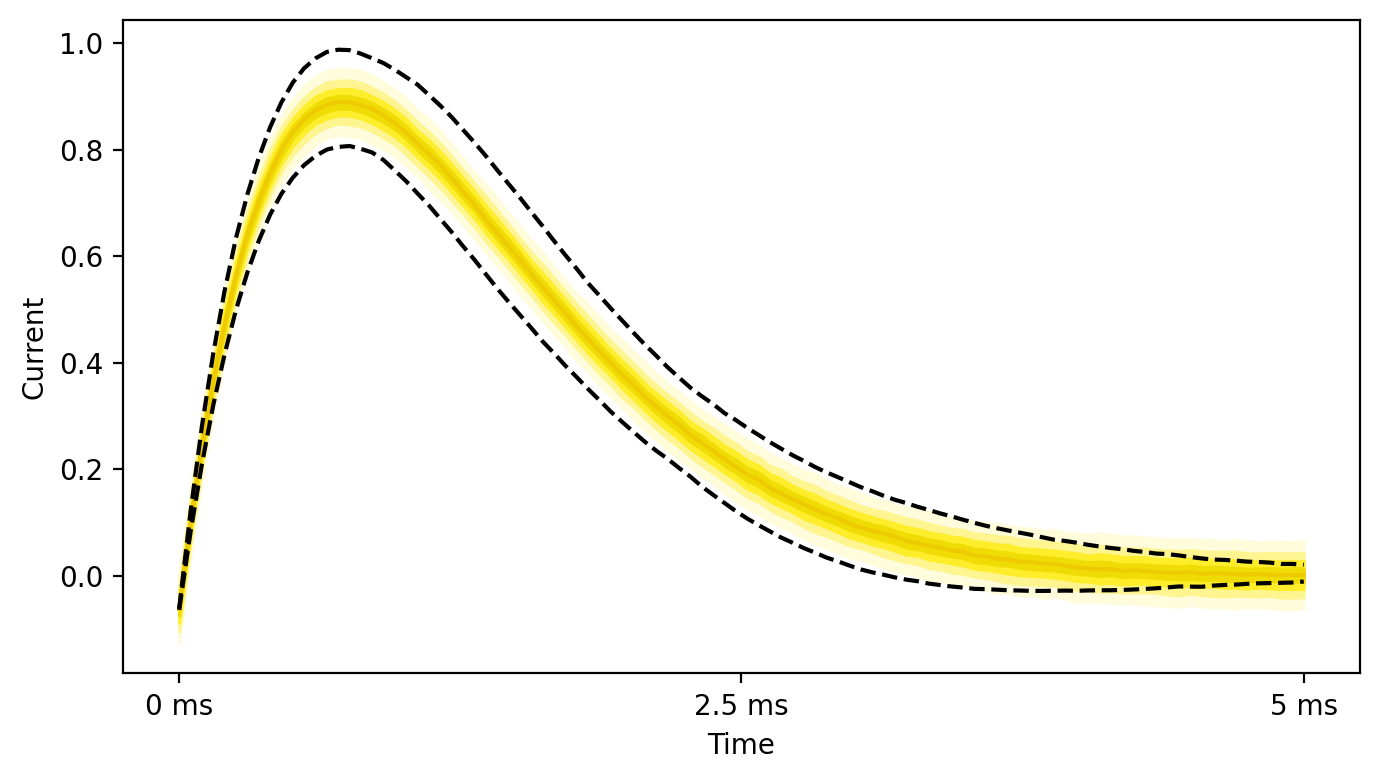

In [12]:
fig, ax_y = plt.subplots(1, 1, figsize=(7, 4), sharex=True)
ax_y = ribbon_plot(time, y_pred, ax_y)
qs = get_quantiles(melted_traj.iloc[:N*M].pivot(index='time',columns='experiment',values='current').values.T, [2.5, 50, 97.5])
ax_y.plot(time,
          qs[0, :], color='black', linestyle='--')
ax_y.plot(time,
          qs[2, :], color='black', linestyle='--')
ax_y.set_ylabel('Current')
ax_y.set_xlabel('Time')
ax_y.set_xticks([0, 2.5, 5])
ax_y.set_xticklabels(['0 ms', '2.5 ms', '5 ms'])
fig.tight_layout()
plt.show()
fig.savefig('current_fit.pdf',bbox_inches='tight')

In [13]:
hyper_prior_current=az.summary(fit_current,var_names=['mu0','sigma0','sigma'])

tex_file = open("table_current_stats.tex", "w")
n = tex_file.write(hyper_prior_current.to_latex())
tex_file.close()


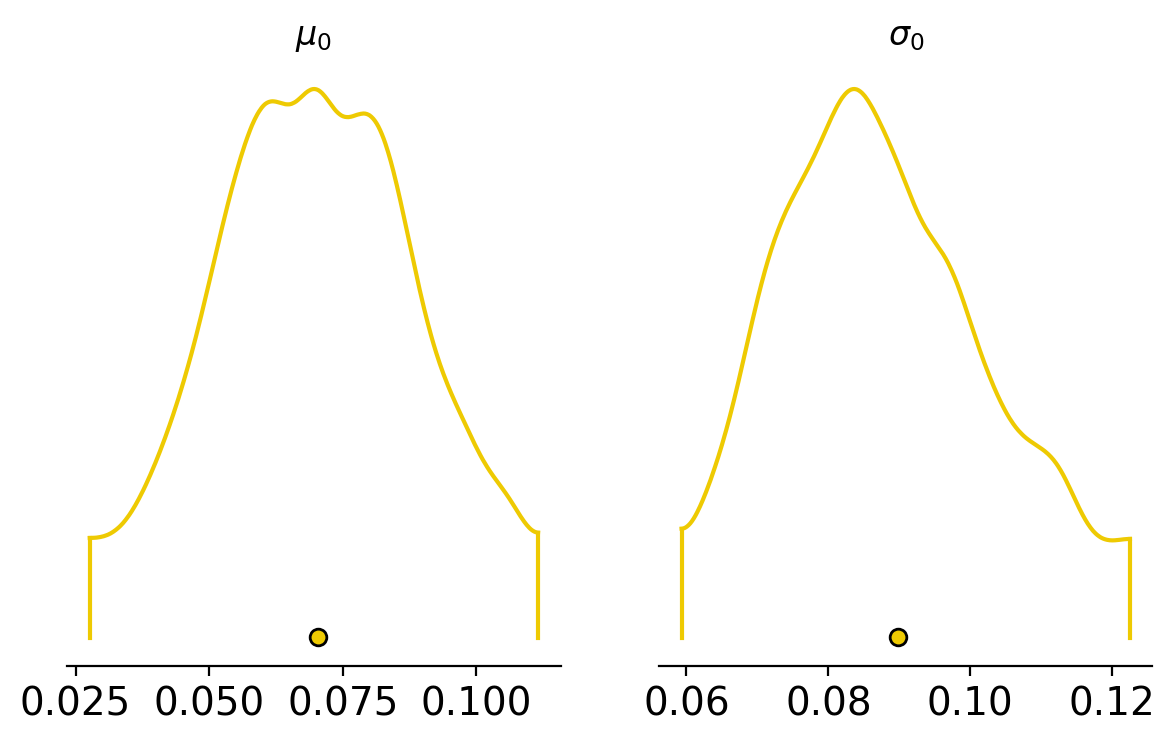

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax = az.plot_density(fit_current,var_names=['mu0','sigma0'],colors=DARK,ax=ax)
ax[0].set_title('$\mu_0$')
ax[1].set_title('$\sigma_0$')

fig.savefig('current_hyperparameters.pdf',bbox_inches='tight')


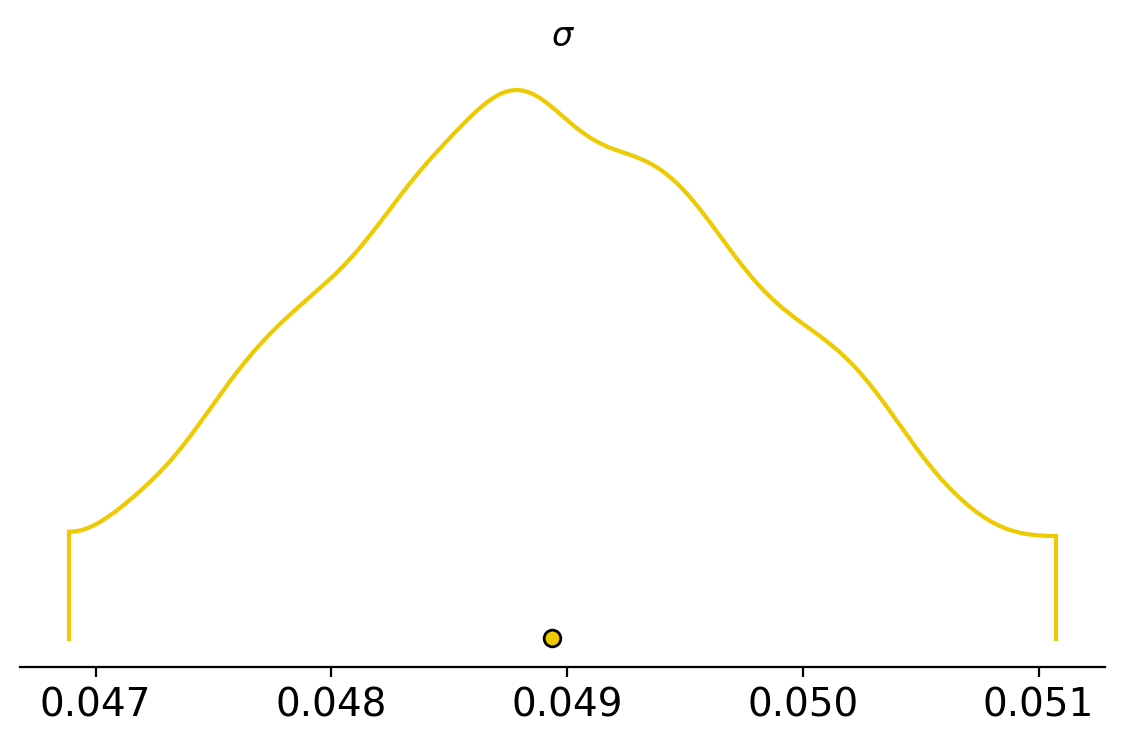

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharex=True)
ax = az.plot_density(fit_current,var_names=['sigma'],colors=DARK,ax=ax)
ax.set_title('$\sigma$')
fig.savefig('current_sigma.pdf',bbox_inches='tight')

In [16]:
data_voltage = dict(N=BN.shape[0],
                 K=BN.shape[1],
                 L=M,
                 x=BN,
                 y=melted_traj.voltage.values[0:N*M])

In [17]:
fit_voltage = spline_fit.sample(data = data_voltage, seed = 14082021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [18]:
y_pred = fit_voltage.stan_variable('y_pred')
beta_healthy = fit_voltage.stan_variable('beta')
mu = fit_voltage.stan_variable('mu')

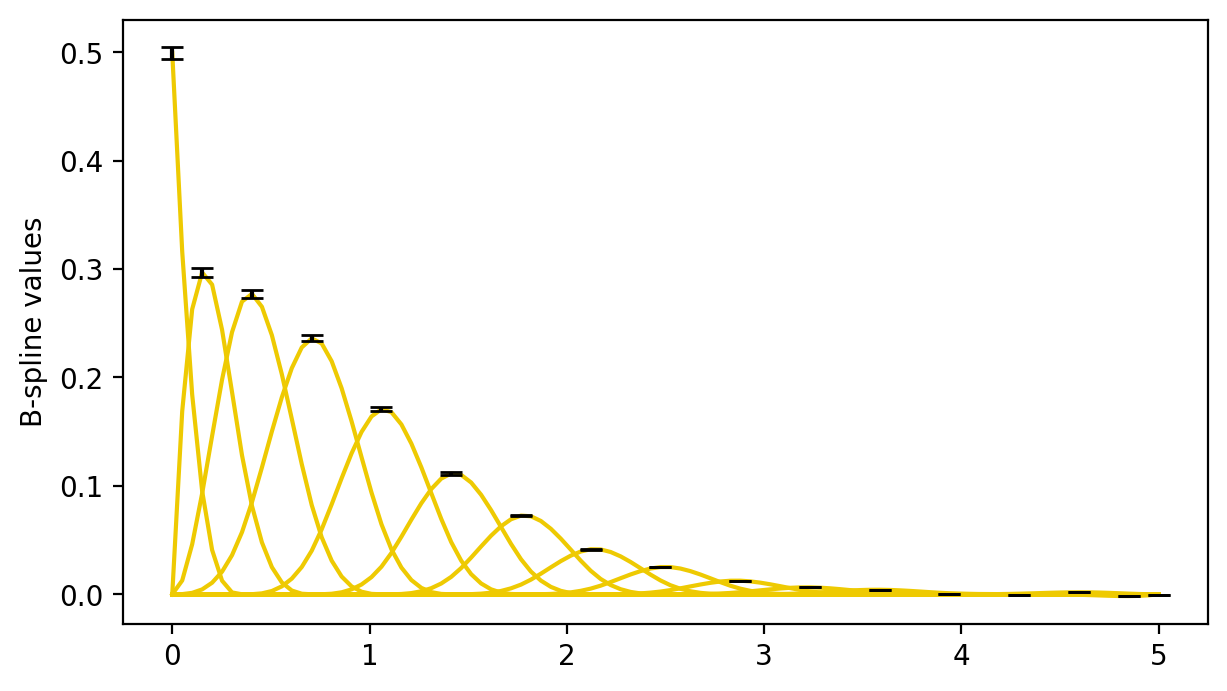

In [19]:
# srednie i odchylenia standardowe (brzegowe dla wspolczynnikow)
mn_beta = np.mean(beta_healthy, axis=0)
sd_beta = np.std(beta_healthy, axis=0)

time=trajectories1.time.values

# Visualisation of individual splines
B0 = BN[0:M]
spline_components = B0@np.diag(mn_beta)
y_m = 0*mn_beta
for i in range(len(y_m)):
    y_m[i] = max(spline_components[:,i].min(), spline_components[:,i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax_spl = plt.subplots(1, 1, figsize=(7, 4), sharex=True)
# #ax2.set_ylim((-1, 14))
for i in range(num_knots+2):
     ax_spl.plot(time,(spline_components[:, i]), color=DARK, zorder=0)
     ax_spl.errorbar(time[x_m[i]], y_m[i], ls='none', yerr=2 * sd_beta[i]*y_m[i], color='black', capsize=4)
ax_spl.set_ylabel('B-spline values')

plt.show()
fig.savefig('spline_voltage_fit.pdf',bbox_inches='tight')

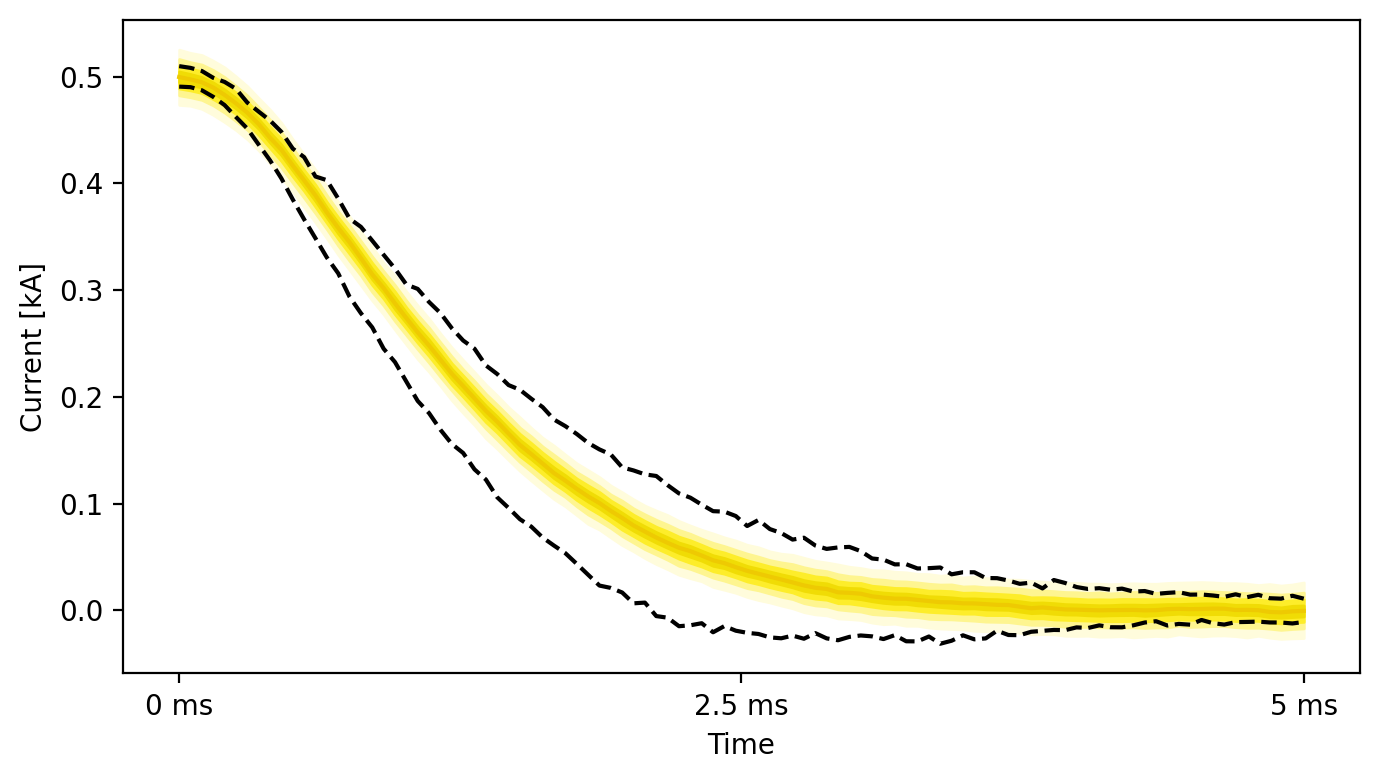

In [20]:
fig, ax_y = plt.subplots(1, 1, figsize=(7, 4), sharex=True)
ax_y = ribbon_plot(time, y_pred, ax_y)
qs = get_quantiles(melted_traj.pivot(index='time',columns='experiment',values='voltage').values.T, [2.5, 50, 97.5])
ax_y.plot(time,
          qs[0, :], color='black', linestyle='--')
ax_y.plot(time,
          qs[2, :], color='black', linestyle='--')
ax_y.set_ylabel('Current [kA]')
ax_y.set_xlabel('Time')
ax_y.set_xticks([0, 2.5, 5])
ax_y.set_xticklabels(['0 ms', '2.5 ms', '5 ms'])
fig.tight_layout()
plt.show()
fig.savefig('voltage_fit.pdf',bbox_inches='tight')

In [21]:
hyper_prior_voltage=az.summary(fit_voltage,var_names=['mu0','sigma0','sigma'])

tex_file = open("table_voltage_stats.tex", "w")
n = tex_file.write(hyper_prior_voltage.to_latex())
tex_file.close()


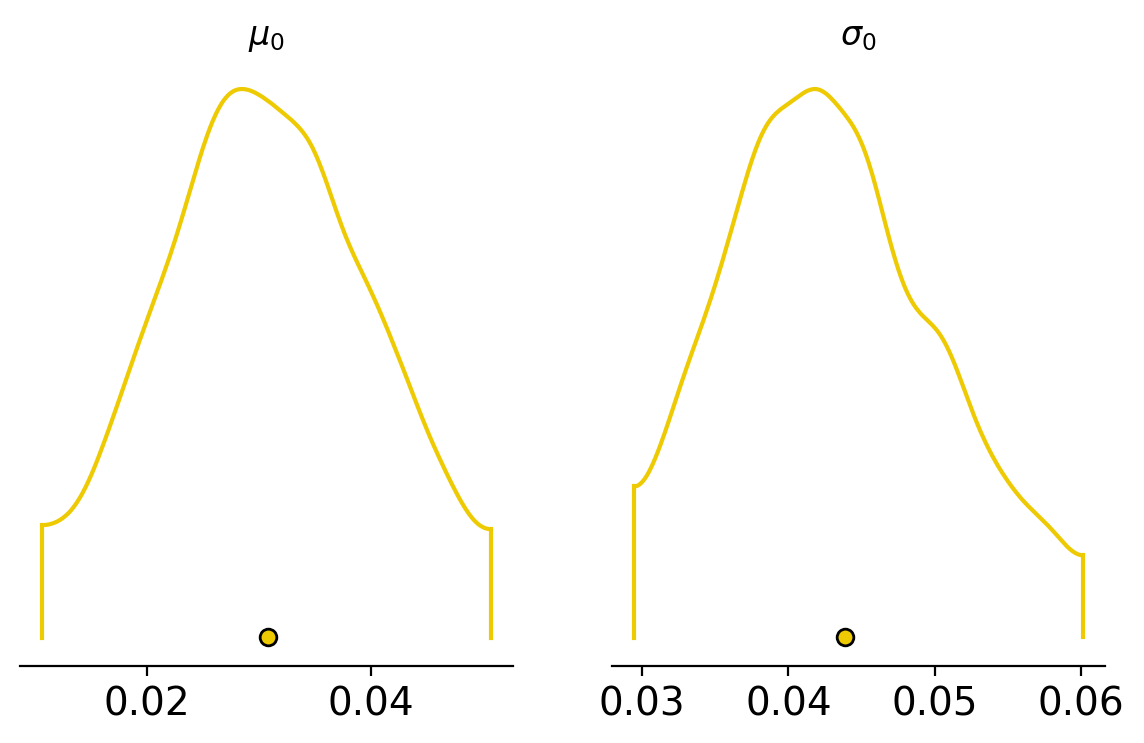

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax = az.plot_density(fit_voltage,var_names=['mu0','sigma0'],colors=DARK,ax=ax)
ax[0].set_title('$\mu_0$')
ax[1].set_title('$\sigma_0$')

fig.savefig('voltage_hyperparameters.pdf',bbox_inches='tight')


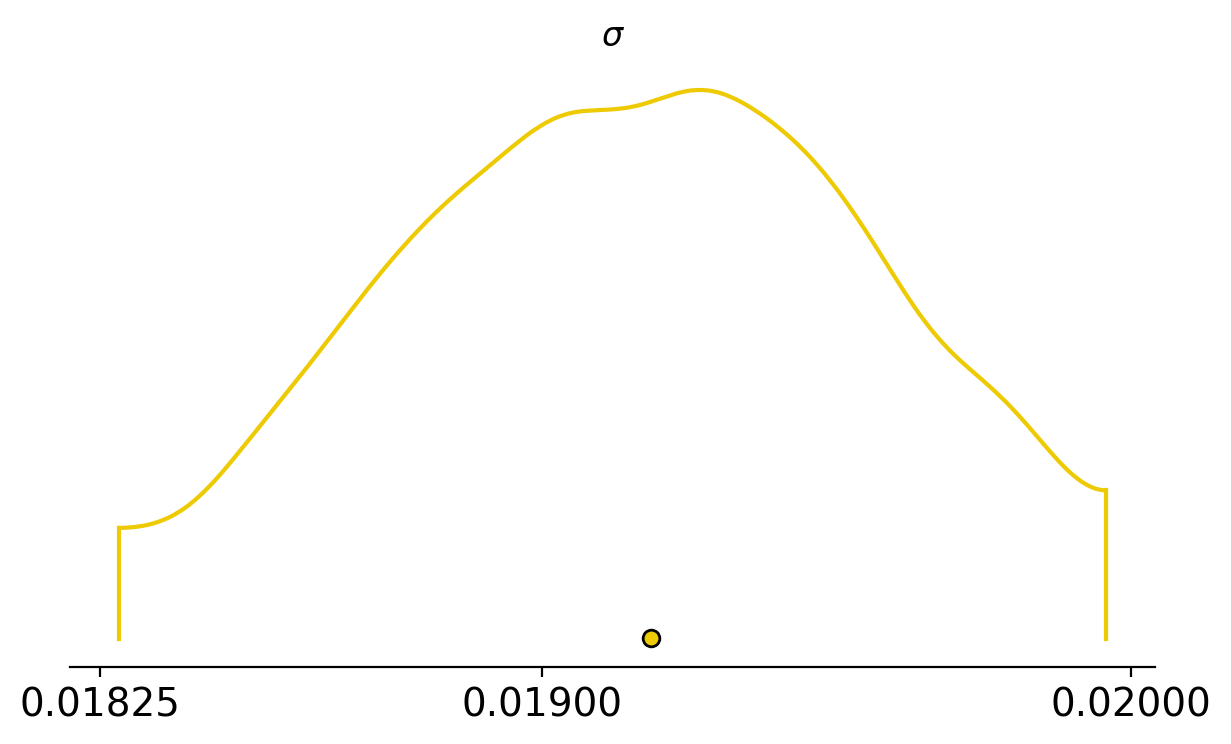

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax =az.plot_density(fit_voltage,var_names=['sigma'],colors=DARK,ax=ax)
ax.set_title('$\sigma$')
ax.set_xticks([0.01825,hyper_prior_voltage.loc['sigma','mean'],0.02])
fig.savefig('voltage_sigma.pdf',bbox_inches='tight')

In [24]:
# ptg data for comparison
melted_traj_ptg = pd.melt(pd.read_csv('ptg_currents.csv',index_col=0), id_vars=['time'], value_vars=trajectories1.columns[0:100],var_name='experiment', value_name='current')
melted_traj_ptg['voltage'] = pd.melt(pd.read_csv('ptg_voltages.csv',index_col=0),id_vars=['time'], value_vars=trajectories1.columns[0:100],var_name='experiment', value_name='voltage')['voltage']

In [25]:
#fit_4_depth = CmdStanModel(stan_file='spline_fit_4_with_prior.stan')

select_traj_ptg = melted_traj_ptg[melted_traj_ptg.experiment=='ex19']['current']
select_traj_ptp = melted_traj[melted_traj.experiment=='ex19']['current']
data_fit2_ptg = dict(N=B0.shape[0],
                 K=B0.shape[1],
                 L=M,
                 x=B0,
                 y=select_traj_ptg.values
                 )

data_fit2_ptp = dict(N=B0.shape[0],
                 K=B0.shape[1],
                 L=M,
                 x=B0,
                 y=select_traj_ptp.values
                 )



In [26]:
fit_ptg = spline_fit.sample(data_fit2_ptg,seed=14082021)
fit_ptp = spline_fit.sample(data_fit2_ptp,seed=14082021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


In [27]:
beta_healthy = fit_current.stan_variable('beta')
beta_ptp = fit_ptp.stan_variable('beta')
beta_ptg = fit_ptg.stan_variable('beta')

y_pred_ptp = fit_ptp.stan_variable('y_pred')
y_pred_ptg = fit_ptg.stan_variable('y_pred')

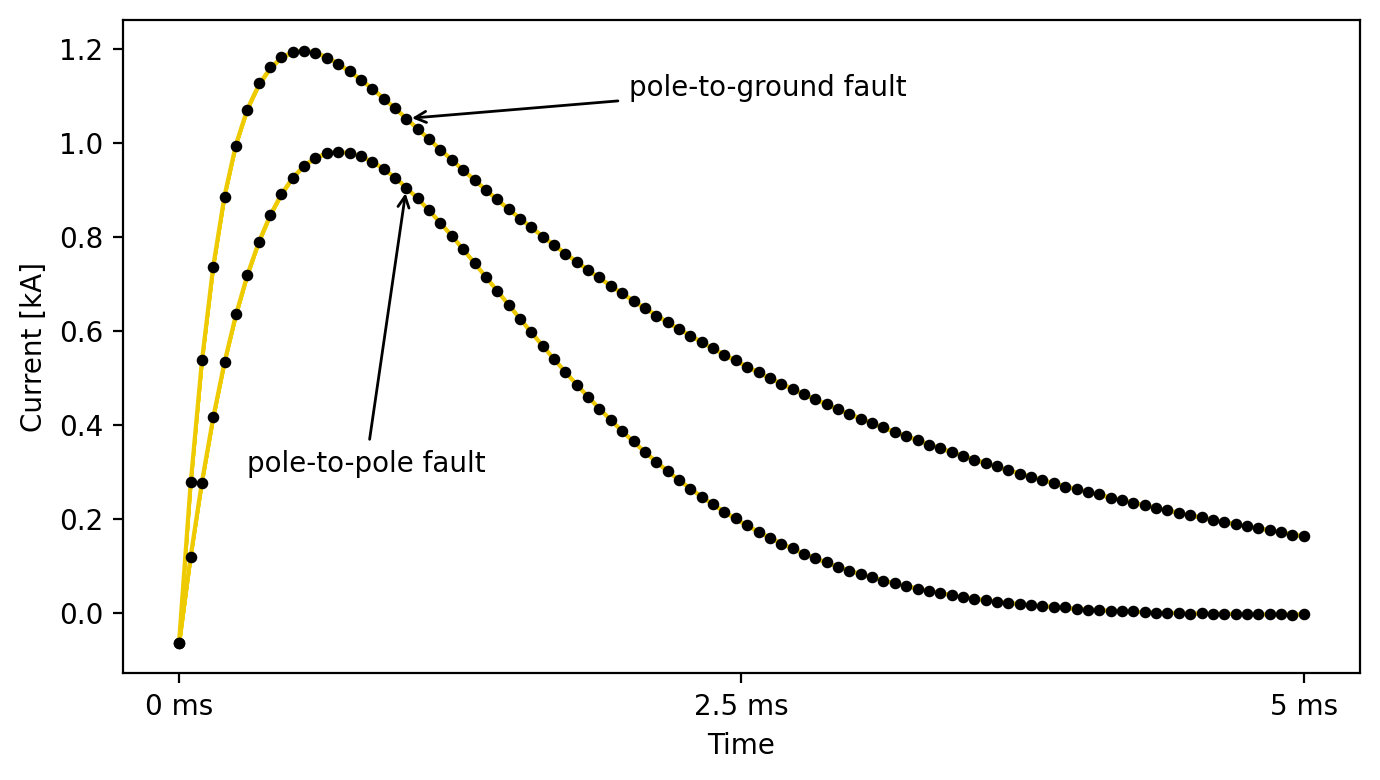

In [28]:
# Visualisation of faulty fit - simulated output

fig, ax_y = plt.subplots(1, 1, figsize=(7, 4), sharex=True)
ax_y = ribbon_plot(time, y_pred_ptp, ax_y)
ax_y.scatter(time,select_traj_ptp,color='black',s=10)
ax_y = ribbon_plot(time, y_pred_ptg, ax_y)
ax_y.scatter(time,select_traj_ptg,color='black',s=10)
ax_y.set_ylabel('Current [kA]')
ax_y.set_xlabel('Time')
ax_y.set_xticks([0, 2.5, 5])
ax_y.set_xticklabels(['0 ms', '2.5 ms', '5 ms'])
ax_y.annotate(text='pole-to-pole fault',xy=(time[20],select_traj_ptp.values[20]),xytext=(.3,0.3),arrowprops={'arrowstyle':'->'})
ax_y.annotate(text='pole-to-ground fault',xy=(time[20],select_traj_ptg.values[20]),xytext=(2,1.1),arrowprops={'arrowstyle':'->'})

fig.tight_layout()
plt.show()
fig.savefig('example_current_fit.pdf',bbox_inches='tight')

/opt/anaconda3/envs/DA2021/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Mean current reference depth 6.230e-02
Max current reference depth 2.140e-01
Min current reference depth 1.993e-02


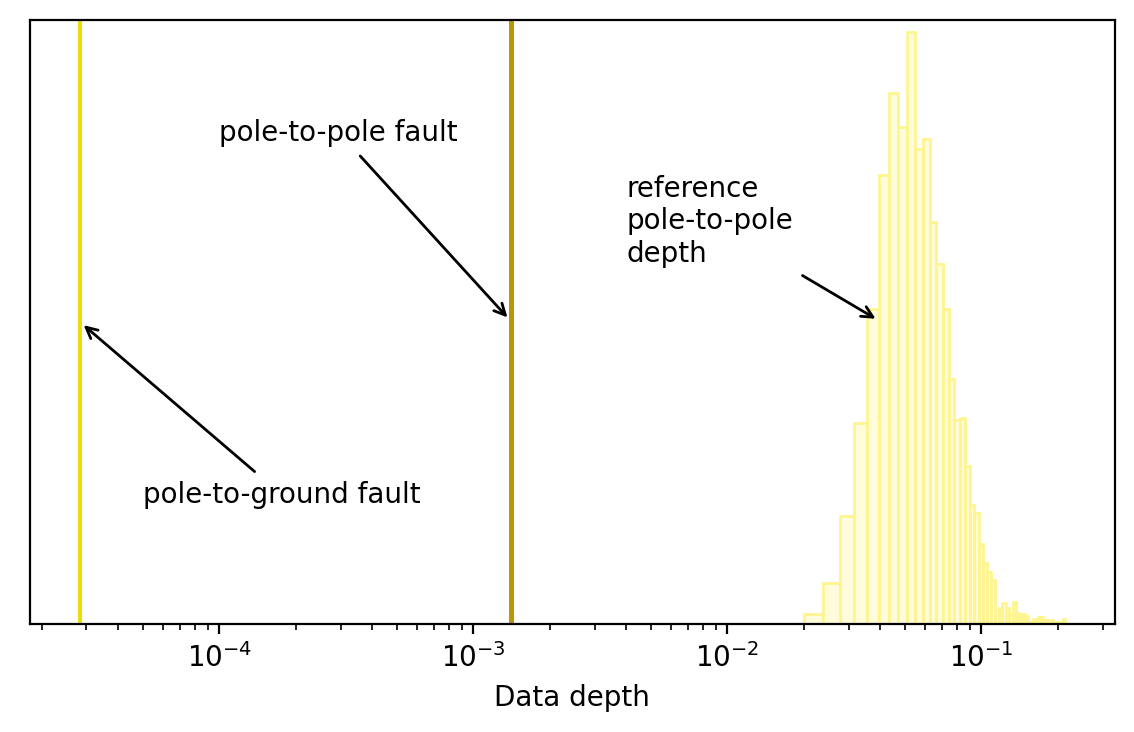

In [29]:
mn_beta = np.mean(beta_healthy, axis=0)
beta_cov = np.cov(beta_healthy.T)
invSigma = np.linalg.inv(beta_cov)



depths_healthy=[]

for b in beta_healthy:
    depths_healthy.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_healthy = np.array(depths_healthy)


print('Mean current reference depth {:.3e}'.format(np.mean(depths_healthy)))
print('Max current reference depth {:.3e}'.format(np.max(depths_healthy)))
print('Min current reference depth {:.3e}'.format(np.min(depths_healthy)))


depths_ptp=[]

for b in beta_ptp:
    depths_ptp.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_ptp = np.array(depths_ptp)

depths_ptg=[]

for b in beta_ptg:
    depths_ptg.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_ptg = np.array(depths_ptg)


fig, axes = plt.subplots(1, 1, figsize=(7, 4),sharex=True)
ax1=axes
ax1.hist(depths_healthy,bins=50,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT, density=True)
ax1.hist(depths_ptp,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT, density=True)
ax1.hist(depths_ptg,bins=20,color=MID,edgecolor=MID_HIGHLIGHT, density=True)
ax1.set_xscale('log')
ax1.set_ylim([0, 25])
ax1.set_yticks([])

ax1.annotate(text='pole-to-pole fault',xy=(np.mean(depths_ptp),12.5),xytext=(1e-4,20),arrowprops={'arrowstyle':'->'})
ax1.annotate(text='pole-to-ground fault',xy=(np.mean(depths_ptg),12.5),xytext=(5e-5,5),arrowprops={'arrowstyle':'->'})
ax1.annotate(text='reference\npole-to-pole\ndepth',xy=(4e-2,12.5),xytext=(4e-3,15),arrowprops={'arrowstyle':'->'})
ax1.set_xlabel('Data depth')

plt.show()
fig.savefig('current_depth_histograms.pdf',bbox_inches='tight')




In [30]:
beta_healthy = fit_current.stan_variable('beta')
mn_beta = np.mean(beta_healthy, axis=0)
beta_cov = np.cov(beta_healthy.T)
invSigma = np.linalg.inv(beta_cov)


depths_healthy=[]

for b in beta_healthy:
    depths_healthy.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_healthy = np.array(depths_healthy)

experiments_ids = list(trajectories1.columns[20:30])
ptp_depths=pd.DataFrame(columns=['mean','min','max'])
ptg_depths=pd.DataFrame(columns=['mean','min','max'])
betas=[]
for id in experiments_ids:
    select_traj = melted_traj[melted_traj.experiment==id]['current']
    data_fit2_ht = dict(N=B0.shape[0],
                    K=B0.shape[1],
                    L=M,
                    x=B0,
                    y=select_traj.values
                    )
    fit_ht = spline_fit.sample(data_fit2_ht,seed=14082021)

    beta_ptp = fit_ht.stan_variable('beta')

    betas.append(beta_ptp)

    depths_ht=[]
    for b in beta_ptp:
        depths_ht.append(mahalanobis_depth(b,mn_beta,invSigma))
    depths_ht = np.array(depths_ht)
    ptp_depths=ptp_depths.append({'mean':np.mean(depths_ht),'min':np.min(depths_ht),'max':np.max(depths_ht)},ignore_index=True)
    select_traj = melted_traj_ptg[melted_traj_ptg.experiment==id]['current']
    data_fit2_ft = dict(N=B0.shape[0],
                    K=B0.shape[1],
                    L=M,
                    x=B0,
                    y=select_traj.values
                    )
    fit_ptg = spline_fit.sample(data_fit2_ft,seed=14082021)

    beta_ptg = fit_ptg.stan_variable('beta')
    depths_ptg=[]
    for b in beta_ptg:
        depths_ptg.append(mahalanobis_depth(b,mn_beta,invSigma))
    depths_ptg = np.array(depths_ptg)
    ptg_depths=ptg_depths.append({'mean':np.mean(depths_ptg),'min':np.min(depths_ptg),'max':np.max(depths_ptg)},ignore_index=True)


/opt/anaconda3/envs/DA2021/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:c

In [31]:
wynik_current = pd.concat({'Pole-to-pole faults':ptp_depths, 'Pole-to-ground faults':ptg_depths, }, axis=1)
wynik_current.index.name = 'Exp. no.'
wynik_current

Pole-to-pole faults                     Pole-to-ground faults  \
                        mean       min       max                  mean   
Exp. no.                                                                 
0                   0.000895  0.000887  0.000903              0.000037   
1                   0.002531  0.002485  0.002575              0.000047   
2                   0.001795  0.001775  0.001817              0.000045   
3                   0.000418  0.000416  0.000421              0.000028   
4                   0.000259  0.000258  0.000260              0.000026   
5                   0.000263  0.000262  0.000264              0.000044   
6                   0.002432  0.002394  0.002467              0.000033   
7                   0.000364  0.000362  0.000366              0.000083   
8                   0.003198  0.003141  0.003260              0.000036   
9                   0.002255  0.002222  0.002290              0.000052   

                              
               min       max  
Exp. no.                      
0         0.000037  0.000038  
1         0.000047  0.000048  
2         0.000044  0.000045  
3         0.000028  0.000028  
4         0.000026  0.000026  
5         0.000043  0.000044  
6         0.000033  0.000033  
7         0.000082  0.000083  
8         0.000036  0.000036  
9         0.000052  0.000052

In [32]:

tex_file = open("table_current_comparison.tex", "w")
n = tex_file.write(wynik_current.to_latex(float_format="%.3e").replace('e-02','$\cdot10^{-2}$')
                                                      .replace('e-03','$\cdot10^{-3}$')
                                                      .replace('e-04','$\cdot10^{-4}$')
                                                      .replace('e-05','$\cdot10^{-5}$'))
tex_file.close()



In [33]:
#fit_4_depth = CmdStanModel(stan_file='spline_fit_4_with_prior.stan')

select_traj_ptg = melted_traj_ptg[melted_traj_ptg.experiment=='ex19']['voltage']
select_traj_ptp = melted_traj[melted_traj.experiment=='ex19']['voltage']
data_fit2_ptg = dict(N=B0.shape[0],
                 K=B0.shape[1],
                 L=M,
                 x=B0,
                 y=select_traj_ptg.values
                 )

data_fit2_ptp = dict(N=B0.shape[0],
                 K=B0.shape[1],
                 L=M,
                 x=B0,
                 y=select_traj_ptp.values
                 )



In [34]:
fit_ptg = spline_fit.sample(data_fit2_ptg,seed=14082021)
fit_ptp = spline_fit.sample(data_fit2_ptp,seed=14082021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [35]:
beta_healthy = fit_voltage.stan_variable('beta')
beta_ptp = fit_ptp.stan_variable('beta')
beta_ptg = fit_ptg.stan_variable('beta')

y_pred_ptp = fit_ptp.stan_variable('y_pred')
y_pred_ptg = fit_ptg.stan_variable('y_pred')

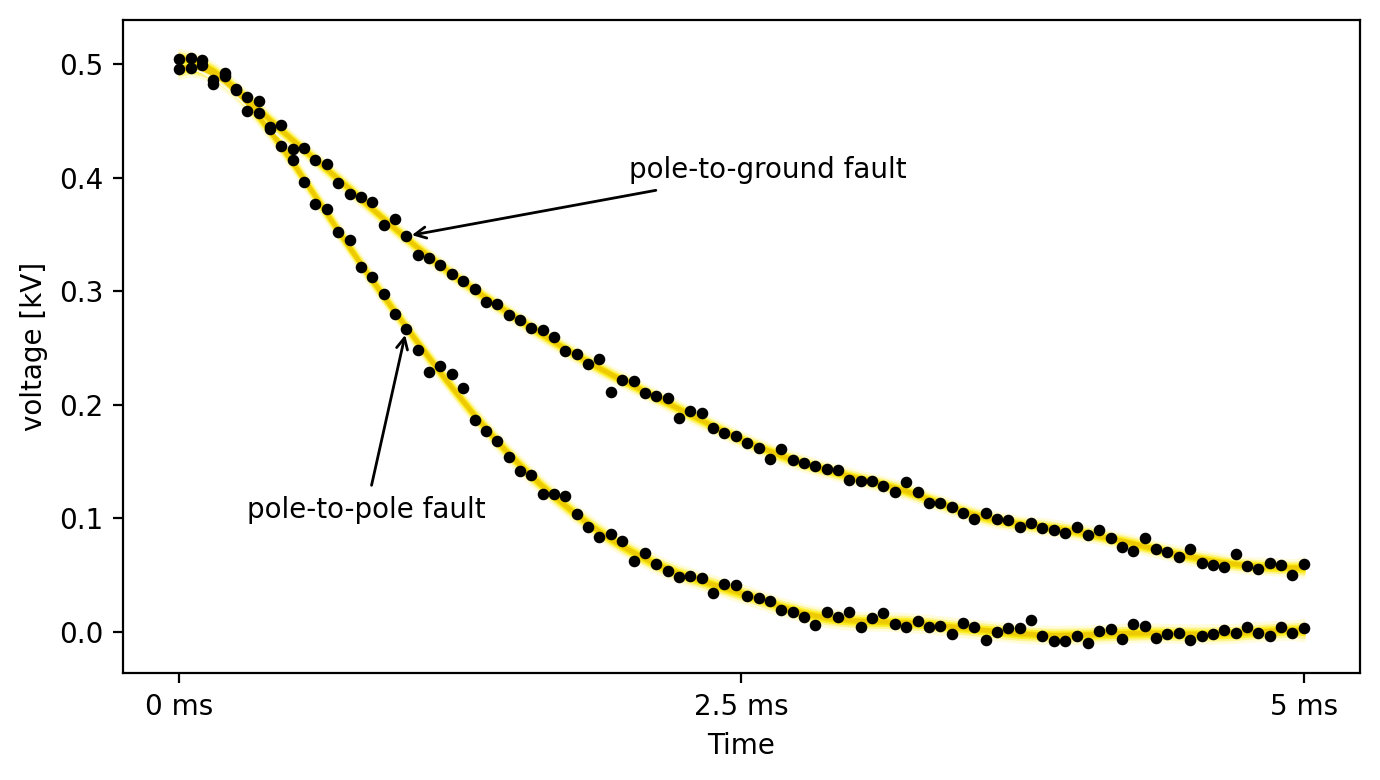

In [36]:
# Visualisation of faulty fit - simulated output

fig, ax_y = plt.subplots(1, 1, figsize=(7, 4))
ax_y = ribbon_plot(time, y_pred_ptp, ax_y)
ax_y.scatter(time,select_traj_ptp,color='black',s=10)
ax_y = ribbon_plot(time, y_pred_ptg, ax_y)
ax_y.scatter(time,select_traj_ptg,color='black',s=10)
ax_y.set_ylabel('voltage [kV]')
ax_y.set_xlabel('Time')
ax_y.set_xticks([0, 2.5, 5])
ax_y.set_xticklabels(['0 ms', '2.5 ms', '5 ms'])
ax_y.annotate(text='pole-to-pole fault',xy=(time[20],select_traj_ptp.values[20]),xytext=(.3,0.1),arrowprops={'arrowstyle':'->'})
ax_y.annotate(text='pole-to-ground fault',xy=(time[20],select_traj_ptg.values[20]),xytext=(2,0.4),arrowprops={'arrowstyle':'->'})

fig.tight_layout()
plt.show()
fig.savefig('example_voltage_fit.pdf',bbox_inches='tight')

/opt/anaconda3/envs/DA2021/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


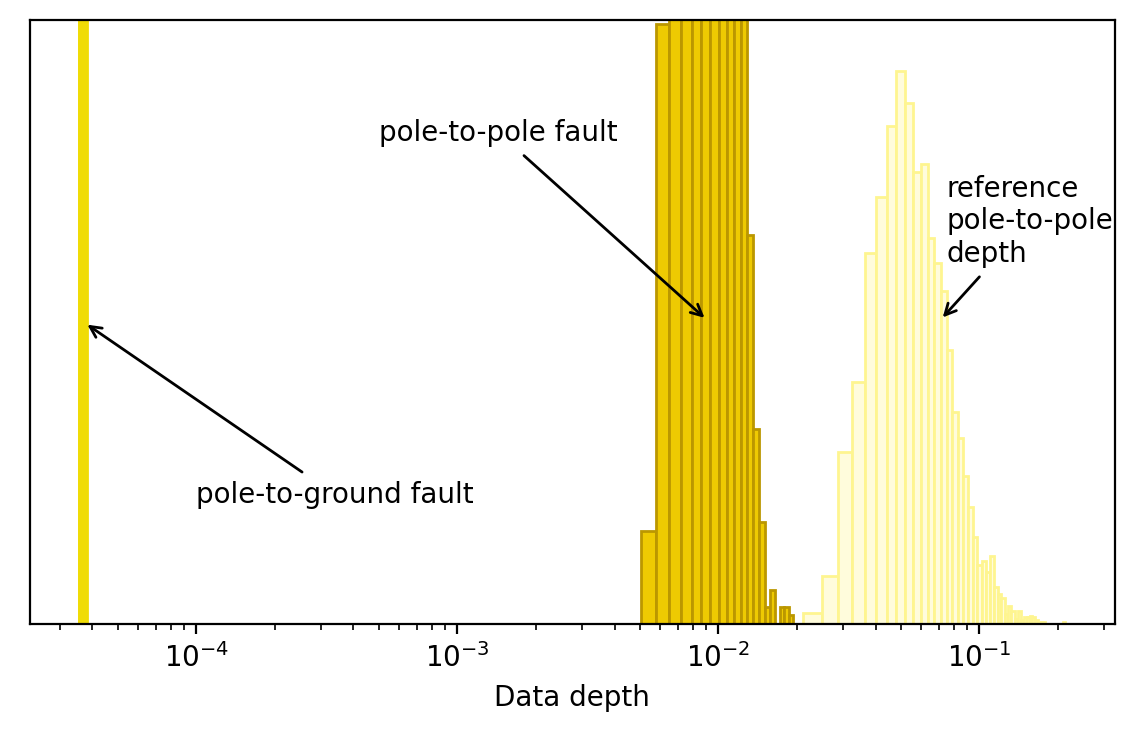

In [37]:
mn_beta = np.mean(beta_healthy, axis=0)
beta_cov = np.cov(beta_healthy.T)
invSigma = np.linalg.inv(beta_cov)



depths_healthy=[]

for b in beta_healthy:
    depths_healthy.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_healthy = np.array(depths_healthy)

depths_ptp=[]

for b in beta_ptp:
    depths_ptp.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_ptp = np.array(depths_ptp)

depths_ptg=[]

for b in beta_ptg:
    depths_ptg.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_ptg = np.array(depths_ptg)


fig, axes = plt.subplots(1, 1, figsize=(7, 4),sharex=True)
ax1=axes
ax1.hist(depths_healthy,bins=50,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT, density=True)
ax1.hist(depths_ptp,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT, density=True)
ax1.hist(depths_ptg,bins=20,color=MID,edgecolor=MID_HIGHLIGHT, density=True)
ax1.set_xscale('log')
ax1.set_ylim([0, 25])
ax1.set_yticks([])

ax1.annotate(text='pole-to-pole fault',xy=(np.mean(depths_ptp),12.5),xytext=(5e-4,20),arrowprops={'arrowstyle':'->'})
ax1.annotate(text='pole-to-ground fault',xy=(np.mean(depths_ptg),12.5),xytext=(1e-4,5),arrowprops={'arrowstyle':'->'})
ax1.annotate(text='reference\npole-to-pole\ndepth',xy=(7e-2,12.5),xytext=(7.5e-2,15),arrowprops={'arrowstyle':'->'})
ax1.set_xlabel('Data depth')

plt.show()
fig.savefig('voltage_depth_histograms.pdf',bbox_inches='tight')

In [38]:
beta_healthy = fit_voltage.stan_variable('beta')
mn_beta = np.mean(beta_healthy, axis=0)
beta_cov = np.cov(beta_healthy.T)
invSigma = np.linalg.inv(beta_cov)


depths_healthy=[]

for b in beta_healthy:
    depths_healthy.append(mahalanobis_depth(b,mn_beta,invSigma))
depths_healthy = np.array(depths_healthy)


print('Mean voltage reference depth {:.3e}'.format(np.mean(depths_healthy)))
print('Max voltage reference depth {:.3e}'.format(np.max(depths_healthy)))
print('Min voltage reference depth {:.3e}'.format(np.min(depths_healthy)))

experiments_ids = list(trajectories1.columns[19:30])
ptp_depths=pd.DataFrame(columns=['mean','min','max'])
ptg_depths=pd.DataFrame(columns=['mean','min','max'])
betas=[]
for id in experiments_ids:
    select_traj = melted_traj[melted_traj.experiment==id]['voltage']
    data_fit2_ht = dict(N=B0.shape[0],
                    K=B0.shape[1],
                    L=M,
                    x=B0,
                    y=select_traj.values
                    )
    fit_ht = spline_fit.sample(data_fit2_ht,seed=14082021)

    beta_ptp = fit_ht.stan_variable('beta')

    betas.append(beta_ptp)

    depths_ht=[]
    for b in beta_ptp:
        depths_ht.append(mahalanobis_depth(b,mn_beta,invSigma))
    depths_ht = np.array(depths_ht)
    ptp_depths=ptp_depths.append({'mean':np.mean(depths_ht),'min':np.min(depths_ht),'max':np.max(depths_ht)},ignore_index=True)
    select_traj = melted_traj_ptg[melted_traj_ptg.experiment==id]['voltage']
    data_fit2_ft = dict(N=B0.shape[0],
                    K=B0.shape[1],
                    L=M,
                    x=B0,
                    y=select_traj.values
                    )
    fit_ptg = spline_fit.sample(data_fit2_ft,seed=14082021)

    beta_ptg = fit_ptg.stan_variable('beta')
    depths_ptg=[]
    for b in beta_ptg:
        depths_ptg.append(mahalanobis_depth(b,mn_beta,invSigma))
    depths_ptg = np.array(depths_ptg)
    ptg_depths=ptg_depths.append({'mean':np.mean(depths_ptg),'min':np.min(depths_ptg),'max':np.max(depths_ptg)},ignore_index=True)


/opt/anaconda3/envs/DA2021/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Mean voltage reference depth 6.223e-02
Max voltage reference depth 2.135e-01
Min voltage reference depth 2.108e-02


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

In [39]:
wynik_voltage = pd.concat({'Pole-to-pole faults':ptp_depths, 'Pole-to-ground faults':ptg_depths, }, axis=1)
wynik_voltage.index.name = 'Exp. no.'
wynik_voltage

Pole-to-pole faults                     Pole-to-ground faults  \
                        mean       min       max                  mean   
Exp. no.                                                                 
0                   0.009176  0.005036  0.019342              0.000037   
1                   0.000428  0.000382  0.000482              0.000067   
2                   0.002489  0.001813  0.003540              0.000026   
3                   0.001124  0.000916  0.001398              0.000023   
4                   0.000726  0.000617  0.000857              0.000048   
5                   0.000188  0.000174  0.000203              0.000110   
6                   0.000116  0.000109  0.000124              0.000208   
7                   0.005456  0.003664  0.008499              0.000031   
8                   0.000630  0.000535  0.000746              0.000054   
9                   0.003252  0.002331  0.005029              0.000039   
10                  0.015209  0.006879  0.037951              0.000030   

                              
               min       max  
Exp. no.                      
0         0.000036  0.000038  
1         0.000064  0.000070  
2         0.000025  0.000027  
3         0.000022  0.000023  
4         0.000046  0.000050  
5         0.000103  0.000120  
6         0.000190  0.000228  
7         0.000029  0.000032  
8         0.000051  0.000057  
9         0.000038  0.000041  
10        0.000029  0.000031

In [40]:

tex_file = open("table_voltage_comparison.tex", "w")
n = tex_file.write(wynik_voltage.to_latex(float_format="%.3e").replace('e-02','$\cdot10^{-2}$')
                                                      .replace('e-03','$\cdot10^{-3}$')
                                                      .replace('e-04','$\cdot10^{-4}$')
                                                      .replace('e-05','$\cdot10^{-5}$'))
tex_file.close()



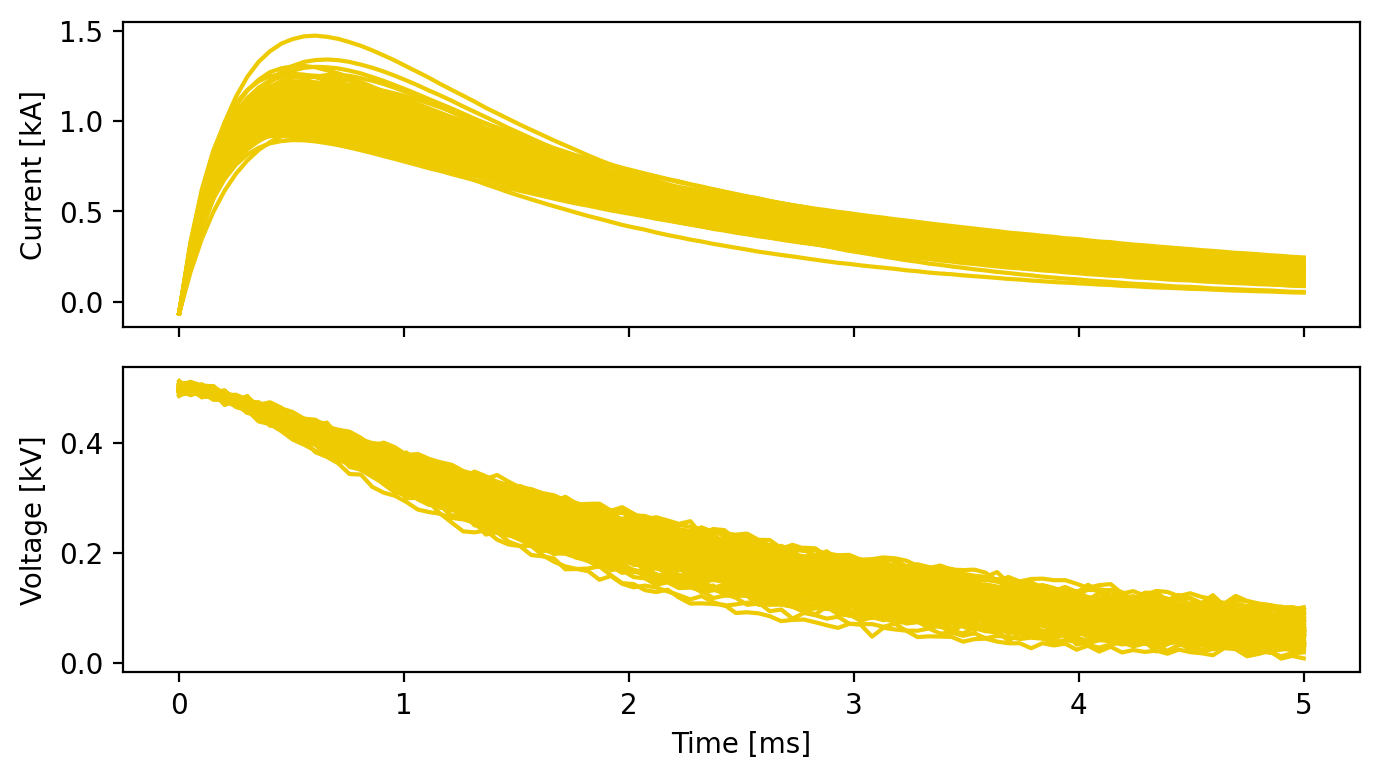

In [41]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize =(7,4),sharex=True)
pd.read_csv('ptg_currents.csv',index_col=101).iloc[:,1:].plot(legend=False,c=DARK,ax=ax1)
ax1.set_ylabel('Current [kA]')
pd.read_csv('ptg_voltages.csv',index_col=101).iloc[:,1:].plot(legend=False,c=DARK,ax=ax2)
ax2.set_ylabel('Voltage [kV]')
ax2.set_xlabel('Time [ms]')

fig.tight_layout()
plt.show()
fig.savefig('ptg_measurements.pdf',bbox_inches='tight')

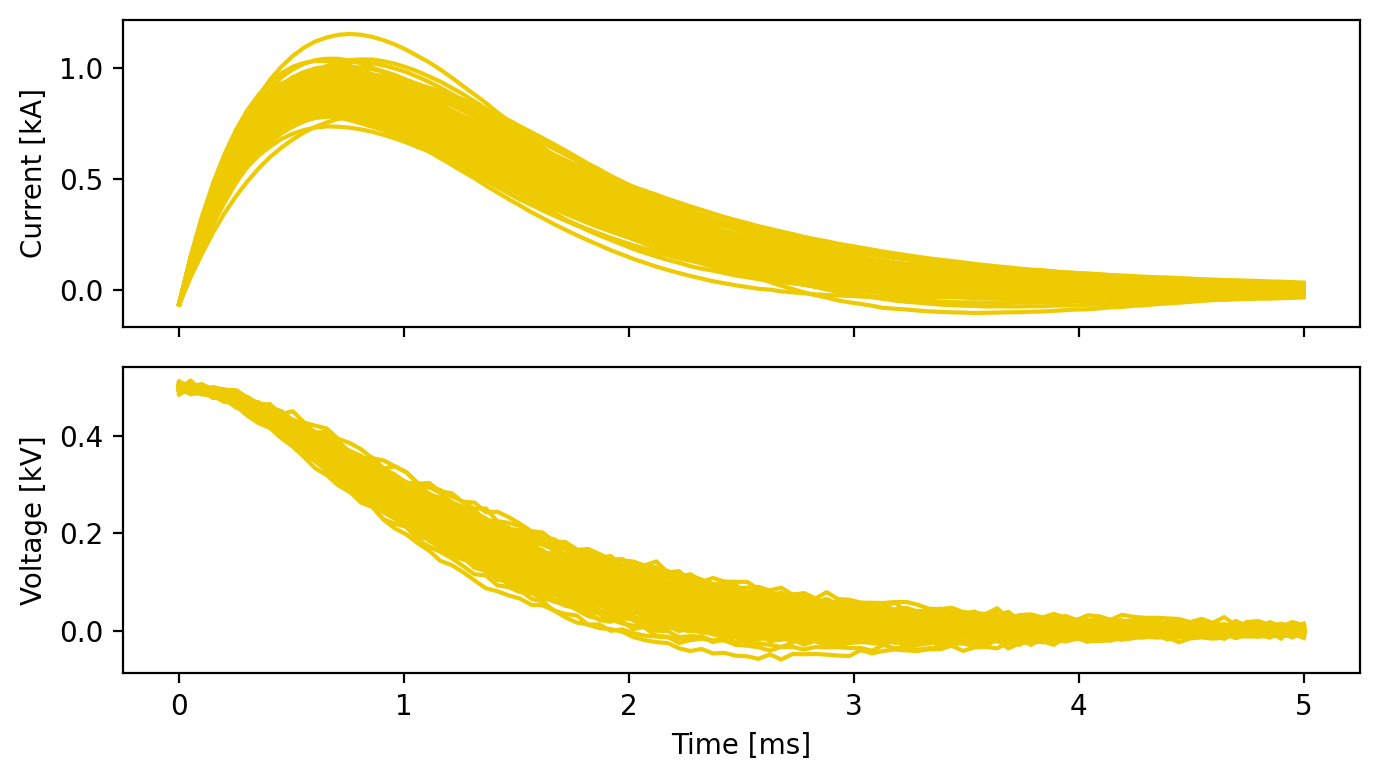

In [42]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize =(7,4),sharex=True)
pd.read_csv('ptp_currents.csv',index_col=101).iloc[:,1:].plot(legend=False,c=DARK,ax=ax1)
ax1.set_ylabel('Current [kA]')
pd.read_csv('ptp_voltages.csv',index_col=101).iloc[:,1:].plot(legend=False,c=DARK,ax=ax2)
ax2.set_ylabel('Voltage [kV]')
ax2.set_xlabel('Time [ms]')

fig.tight_layout()
plt.show()
fig.savefig('ptp_measurements.pdf',bbox_inches='tight')